- initial QC mode
- on the fly function calling and prompting

In [4]:
import os
import json
import base64
from typing import TypedDict, List, Dict, Any, Optional, Literal

import numpy as np
import matplotlib.pyplot as plt  # still used indirectly in tools
from scipy.signal import welch, spectrogram  # may be unused here now

from dotenv import load_dotenv
import tiktoken

from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, END
from openai import OpenAI

# ---------- 0. Token safeguards ----------

# Use GPT-4o tokenizer
enc = tiktoken.encoding_for_model("gpt-4o")


def prompt_to_text(prompt_obj):
    return prompt_obj.to_string() if hasattr(prompt_obj, "to_string") else str(prompt_obj)


def count_tokens(text: str) -> int:
    """Count tokens using GPT-4o tokenizer."""
    return len(enc.encode(text))


def enforce_token_limit(payload: str, max_tokens: int, context_name: str = "") -> str:
    """
    Ensures the payload stays under the token limit.
    Raises ValueError if it doesn't.
    """
    tok = count_tokens(payload)
    if tok > max_tokens:
        raise ValueError(
            f"[TOKEN LIMIT EXCEEDED in {context_name}] "
            f"Payload has {tok} tokens, exceeds limit of {max_tokens}. "
            f"Reduce numeric payload or increase reduction."
        )
    return payload


def reduce_numeric_results(numeric_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Compress large numeric analysis results (FFT, PSD, spectrogram)
    into small summary statistics that are safe to send to the LLM.
    """
    reduced: Dict[str, Any] = {}

    for key, value in numeric_results.items():
        # 1. Fourier spectrum
        if key == "fourier":
            freqs = value["freqs"]
            fft_vals = value["fft"]

            peaks = sorted(
                zip(freqs, fft_vals),
                key=lambda x: abs(x[1]),
                reverse=True,
            )[:10]

            reduced[key] = {
                "top_peaks": [
                    {"freq": float(f), "amp": float(a)} for f, a in peaks
                ],
                "max_amp": float(max(fft_vals)),
                "min_amp": float(min(fft_vals)),
                "n_samples": len(fft_vals),
            }

        # 2. PSD
        elif key == "psd":
            freqs = value["freqs"]
            psd_vals = value["psd"]

            peaks = sorted(
                zip(freqs, psd_vals),
                key=lambda x: abs(x[1]),
                reverse=True,
            )[:10]

            reduced[key] = {
                "top_peaks": [
                    {"freq": float(f), "power": float(p)} for f, p in peaks
                ],
                "max_power": float(max(psd_vals)),
                "mean_power": float(np.mean(psd_vals)),
                "n_freqs": len(psd_vals),
            }

        # 3. Spectrogram
        elif key == "spectrogram":
            Sxx = np.array(value["sxx"])
            reduced[key] = {
                "shape": list(Sxx.shape),
                "max_power": float(Sxx.max()),
                "mean_power": float(Sxx.mean()),
                "median_power": float(np.median(Sxx)),
                "dominant_freq_bin": int(np.argmax(Sxx.mean(axis=1))),
            }

        # 4. Simple scalar stats (variance, snr, etc. or metadata snapshot)
        else:
            reduced[key] = value

    reduced["_note"] = "Numeric arrays were reduced to summary statistics before LLM."
    return reduced


# ---------- 0.1 Build Tools Catalog ----------

from tools_schema import TOOLS_SCHEMAS  # must define TOOLS_SCHEMAS separately


def build_tool_catalog_str() -> str:
    lines = []
    for t in TOOLS_SCHEMAS:
        lines.append(f"- {t['name']}: {t['description']}")
        params = t["parameters"]["properties"]
        if params:
            for pname, pinfo in params.items():
                desc = pinfo.get("description", "")
                default = pinfo.get("default", None)
                if default is not None:
                    lines.append(f"    - {pname} (default={default}): {desc}")
                else:
                    lines.append(f"    - {pname}: {desc}")
    return "\n".join(lines)


# ---------- 1. Pydantic models ----------

InspectionGoal = Literal["initial", "validation"]


class ToolCall(BaseModel):
    tool: str                 # e.g. "compute_fft"
    args: Dict[str, Any] = {} # arguments excluding 'data' and 'metadata'


class PlannerOutput(BaseModel):
    calls: List[ToolCall]
    rationale: str


class ExecutionOutput(BaseModel):
    numeric_results: Dict[str, Any]
    image_paths: List[str]
    metadata: Dict[str, Any]


class Interpretation(BaseModel):
    findings: Dict[str, Any]
    rationale: str


class FusionOutput(BaseModel):
    merged_findings: Dict[str, Any]


class InspectionSummary(BaseModel):
    issues_detected: List[str]
    metrics: Dict[str, Any]
    visual_findings: List[str]
    metadata_notes: List[str]
    final_summary: str


class InterpreterPrompts(BaseModel):
    image_prompt: str
    numeric_prompt: str
    domain_prompt: str
    rationale: str


# ---------- 2. LangGraph state ----------

class InspectionState(TypedDict, total=False):
    # static inputs
    goal: str
    raw_data: List[float]
    metadata: Dict[str, Any]

    # pipeline intermediates
    planner_output: PlannerOutput
    interpreter_prompts: InterpreterPrompts
    execution_output: ExecutionOutput

    image_interp: Interpretation
    numeric_interp: Interpretation
    domain_interp: Interpretation

    fusion_output: FusionOutput
    inspection_summary: InspectionSummary


# ---------- 3. LLM setup ----------

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise RuntimeError("OPENAI_API_KEY not set. Add it to .env or export it before running.")

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    api_key=openai_api_key,
)

vision_client = OpenAI(api_key=openai_api_key)


# ---------- 4. Planner node (tool-calling) ----------

planner_parser = PydanticOutputParser(pydantic_object=PlannerOutput)

TOOLS_CATALOG_TEXT = build_tool_catalog_str()

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a planner for a neural electrophysiology data inspection pipeline.

You DO NOT write code. Instead, you decide which analysis TOOLS to call and
with what parameters.

You have access to the following tools:

{tools_catalog}

Rules:
- Only select tools that are relevant to the user's goal and metadata.
- Prefer a small set of informative tools over calling everything.
- For each tool, choose reasonable arguments (e.g., sampling_rate from metadata).
- Do NOT include the raw data as an argument (it is passed automatically by the system).
- Return a list of tool calls.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}",
        ),
    ]
).partial(
    format_instructions=planner_parser.get_format_instructions(),
    tools_catalog=TOOLS_CATALOG_TEXT,
)


def planner_node(state: InspectionState) -> Dict[str, Any]:
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = planner_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="planner",
    )

    result = llm.invoke(formatted)
    planner_output = planner_parser.parse(result.content)
    return {"planner_output": planner_output}


# ---------- 5. Prompt-policy node (dynamic interpreter prompts) ----------

interpreter_prompts_parser = PydanticOutputParser(pydantic_object=InterpreterPrompts)

prompt_policy_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a PROMPT-POLICY generator for interpreters in a neural electrophysiology
data inspection pipeline.

Your job is to generate three INTERPRETER INSTRUCTION prompts:

1) image_prompt  - how the image interpreter should analyze plots (FFT, PSD, spectrogram, etc.)
2) numeric_prompt - how the numeric interpreter should analyze summary numeric results
3) domain_prompt - how the domain interpreter should analyze metadata and tool choices

You must:
- Tailor prompts to the inspection goal (initial vs validation).
- Tailor prompts to the metadata (sampling_rate, electrode_type, etc.).
- Tailor prompts to the tools selected by the planner.
- Avoid generic advice; be specific and hypothesis-driven.
- Focus on artifacts, signal quality, and appropriateness of recording parameters.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}\nSelected tools: {tools}\nPlanner rationale: {planner_rationale}",
        ),
    ]
).partial(format_instructions=interpreter_prompts_parser.get_format_instructions())


def prompt_policy_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = prompt_policy_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
        tools=json.dumps([c.tool for c in planner_output.calls]),
        planner_rationale=planner_output.rationale,
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="prompt_policy",
    )

    result = llm.invoke(formatted)
    prompts = interpreter_prompts_parser.parse(result.content)
    return {"interpreter_prompts": prompts}


# ---------- 6. Execution node (numeric + plots via tools) ----------

import tools  # your tools.py


def execution_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    raw = np.array(state["raw_data"], dtype=float)
    meta = state.get("metadata", {})

    numeric_results: Dict[str, Any] = {}
    image_paths: List[str] = []

    for call in planner_output.calls:
        tool_name = call.tool
        args = dict(call.args)  # copy

        if not hasattr(tools, tool_name):
            raise RuntimeError(f"Unknown tool selected by planner: {tool_name}")

        func = getattr(tools, tool_name)

        # Inject sampling_rate if function expects it and it's available
        if "sampling_rate" in func.__code__.co_varnames:
            if "sampling_rate" not in args and "sampling_rate" in meta:
                args["sampling_rate"] = float(meta["sampling_rate"])

        # Special-case: tools that operate on metadata instead of data
        if tool_name == "metadata_snapshot_tool":
            out = func(metadata=meta, **{k: v for k, v in args.items() if k != "metadata"})
        else:
            out = func(data=raw, **args)

        nr = out.get("numeric_results", {})
        imgs = out.get("image_paths", [])

        # Merge numeric_results (later tools can overwrite earlier keys if necessary)
        for k, v in nr.items():
            numeric_results[k] = v

        image_paths.extend(imgs)

    exec_out = ExecutionOutput(
        numeric_results=numeric_results,
        image_paths=image_paths,
        metadata=meta,
    )
    return {"execution_output": exec_out}


# ---------- 7. Image interpreter node (vision, using dynamic prompt) ----------

image_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)


def image_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    image_paths = exec_out.image_paths

    if not image_paths:
        interp = Interpretation(
            findings={},
            rationale="No plots were generated to inspect."
        )
        return {"image_interp": interp}

    prompts: InterpreterPrompts = state["interpreter_prompts"]

    # ---- Build multimodal content for GPT-4o ----
    user_content: List[Dict[str, Any]] = [
        {
            "type": "text",
            "text": (
                prompts.image_prompt
                + "\n\nRespond ONLY with a JSON object following this schema:\n\n"
                f"{image_interp_parser.get_format_instructions()}"
            ),
        }
    ]

    for path in image_paths:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode("utf-8")

        user_content.append(
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{b64}"
                }
            }
        )

    try:
        result = vision_client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": user_content,
                }
            ],
            max_tokens=1024,
        )

        msg_content = result.choices[0].message.content
        if isinstance(msg_content, list):
            response_text = " ".join(
                block.get("text", "") if isinstance(block, dict) else str(block)
                for block in msg_content
            )
        else:
            response_text = msg_content

    except Exception as e:
        interp = Interpretation(
            findings={},
            rationale=f"Vision model error: {str(e)}",
        )
        return {"image_interp": interp}

    try:
        interp = image_interp_parser.parse(response_text)
    except Exception as e:
        interp = Interpretation(
            findings={},
            rationale=f"Failed to parse vision JSON: {response_text[:500]} ... Error: {str(e)}",
        )
        return {"image_interp": interp}

    return {"image_interp": interp}


# ---------- 8. Numeric interpreter node (dynamic prompt) ----------

numeric_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)


def numeric_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    reduced = reduce_numeric_results(exec_out.numeric_results)
    payload = json.dumps(reduced)

    message = (
        prompts.numeric_prompt
        + "\n\nNumeric results (JSON): "
        + payload
        + "\n\nRespond ONLY in this JSON format:\n"
        + numeric_interp_parser.get_format_instructions()
    )

    message = enforce_token_limit(
        message,
        max_tokens=6000,
        context_name="numeric_interpreter",
    )

    result = llm.invoke(message)
    interp = numeric_interp_parser.parse(result.content)
    return {"numeric_interp": interp}


# ---------- 9. Domain interpreter node (dynamic prompt) ----------

domain_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)


def domain_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    meta = exec_out.metadata
    meta_json = json.dumps(meta)

    message = (
        prompts.domain_prompt
        + "\n\nMetadata (JSON): "
        + meta_json
        + "\n\nRespond ONLY in this JSON format:\n"
        + domain_interp_parser.get_format_instructions()
    )

    message = enforce_token_limit(
        message,
        max_tokens=4000,
        context_name="domain_interpreter",
    )

    result = llm.invoke(message)
    interp = domain_interp_parser.parse(result.content)
    return {"domain_interp": interp}


# ---------- 10. Fusion node ----------

def fusion_node(state: InspectionState) -> Dict[str, Any]:
    merged: Dict[str, Any] = {}

    for interp_key in ("image_interp", "numeric_interp", "domain_interp"):
        interp: Optional[Interpretation] = state.get(interp_key)  # type: ignore
        if interp:
            for k, v in interp.findings.items():
                merged[k] = v

    fusion = FusionOutput(merged_findings=merged)
    return {"fusion_output": fusion}


# ---------- 11. Summary node ----------

summary_parser = PydanticOutputParser(pydantic_object=InspectionSummary)

summary_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a summarizer for a neural data INSPECTION NODE.
You will be given:
- Merged findings from multiple interpreters
- Numeric results (already reduced)
- Individual interpreter rationales

Your job:
1. List concrete issues detected (noise, artifacts, metadata problems).
2. Summarize key metrics (SNR, variance, etc.).
3. Extract any important visual or numeric observations.
4. Add concise metadata-related notes.
5. Write a short final summary (2-4 sentences) suitable for a lab notebook.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Merged findings: {merged_findings}\nNumeric results: {numeric_results}\n"
            "Image rationale: {image_rationale}\nNumeric rationale: {numeric_rationale}\n"
            "Domain rationale: {domain_rationale}",
        ),
    ]
).partial(format_instructions=summary_parser.get_format_instructions())


def summary_node(state: InspectionState) -> Dict[str, Any]:
    fusion = state["fusion_output"]
    exec_out = state["execution_output"]
    img = state.get("image_interp")
    num = state.get("numeric_interp")
    dom = state.get("domain_interp")

    reduced_num = reduce_numeric_results(exec_out.numeric_results)

    formatted = summary_prompt.format(
        merged_findings=json.dumps(fusion.merged_findings),
        numeric_results=json.dumps(reduced_num),
        image_rationale=getattr(img, "rationale", "") if img else "",
        numeric_rationale=getattr(num, "rationale", "") if num else "",
        domain_rationale=getattr(dom, "rationale", "") if dom else "",
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=6000,
        context_name="summary",
    )

    result = llm.invoke(formatted)
    summary = summary_parser.parse(result.content)
    return {"inspection_summary": summary}


# ---------- 12. Build LangGraph ----------

def build_inspection_graph():
    graph = StateGraph(
        InspectionState,
        config={
            "static": ["goal", "raw_data", "metadata"]
        }
    )

    graph.add_node("planner", planner_node)
    graph.add_node("prompt_policy", prompt_policy_node)
    graph.add_node("execute", execution_node)
    graph.add_node("image_interp", image_interpreter_node)
    graph.add_node("numeric_interp", numeric_interpreter_node)
    graph.add_node("domain_interp", domain_interpreter_node)
    graph.add_node("fusion", fusion_node)
    graph.add_node("summary", summary_node)

    graph.set_entry_point("planner")
    graph.add_edge("planner", "prompt_policy")
    graph.add_edge("prompt_policy", "execute")
    graph.add_edge("execute", "image_interp")
    graph.add_edge("execute", "numeric_interp")
    graph.add_edge("execute", "domain_interp")
    graph.add_edge("image_interp", "fusion")
    graph.add_edge("numeric_interp", "fusion")
    graph.add_edge("domain_interp", "fusion")
    graph.add_edge("fusion", "summary")
    graph.add_edge("summary", END)

    return graph.compile()


In [5]:
# ---------- 12. Example usage ----------

if __name__ == "__main__":
    app = build_inspection_graph()

    # Fake toy data: sine wave + 60 Hz noise
    fs = 30000.0
    t = np.arange(0, 1.0, 1.0 / fs)
    raw = 50 * np.sin(2 * np.pi * 100 * t) + 5 * np.sin(2 * np.pi * 60 * t)

    initial_state: InspectionState = {
        "goal": "initial",
        "raw_data": raw.tolist(),
        "metadata": {
            "sampling_rate": fs,
            "units": "uV",
            "electrode_type": "cuff",
        },
    }

    def safe_serialize(obj):
        if hasattr(obj, "model_dump"):
            return safe_serialize(obj.model_dump())
        if isinstance(obj, np.ndarray):
            return f"np.ndarray(shape={obj.shape})"
        if isinstance(obj, list):
            if len(obj) > 50:   # truncate long lists
                return f"[...{len(obj)} items...]"
            return [safe_serialize(v) for v in obj]
        if isinstance(obj, dict):
            return {k: safe_serialize(v) for k, v in obj.items()}
        return obj

    print("=== DEBUG STREAM OF PIPELINE ===")

    for event in app.stream(initial_state):
        print("\n--- NODE:", event["node"] if "node" in event else "UNKNOWN", "---")
        print(json.dumps(safe_serialize(event), indent=2))

    print("\n=== FINAL RESULT ===")
    final_state = app.invoke(initial_state)
    print(final_state["inspection_summary"])


=== DEBUG STREAM OF PIPELINE ===

--- NODE: UNKNOWN ---
{
  "planner": {
    "planner_output": {
      "calls": [
        {
          "tool": "compute_fft",
          "args": {
            "sampling_rate": 30000.0,
            "max_freq": 15000.0,
            "make_plot": true,
            "label": "Fourier Transform"
          }
        },
        {
          "tool": "compute_psd",
          "args": {
            "sampling_rate": 30000.0,
            "nperseg": 2048,
            "make_plot": true,
            "label": "Power Spectral Density"
          }
        },
        {
          "tool": "compute_channel_stats_tool",
          "args": {}
        }
      ],
      "rationale": "For an initial inspection of the neural electrophysiology data, it is important to understand the frequency content and basic statistics of the signal. The FFT and PSD will help identify any line noise, dominant frequencies, or broadband activity, which are common concerns in neural recordings. The channel s

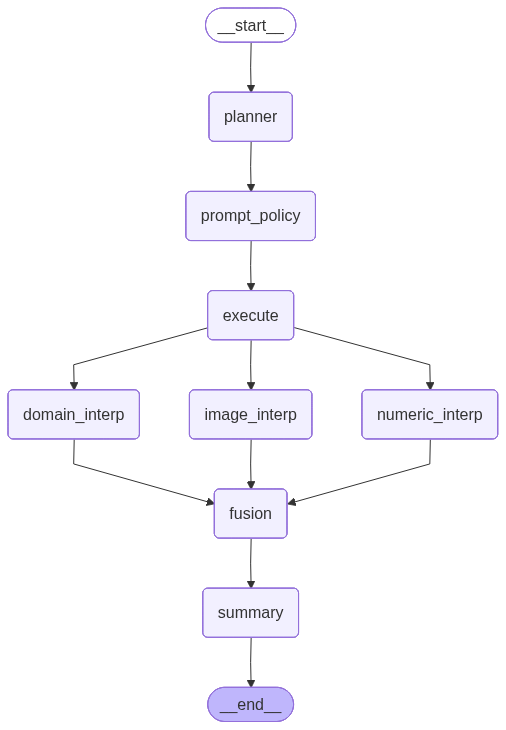

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {str(e)}")